We begin by importing a set of standard Python libraries. If you just downloaded the nDspec repository but did not install it with pip/conda, you can tell your system to look for it with the sys.path.append line.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import gc

sys.path.append('/home/matteo/Software/nDspec/src/')

We will fit three datasets of increasing complexity: a powerspectrum, ie a real number, a Fourier-frequency dependent cross spectrum with a single subject band, and a set of six lag-energy spectra. 

Normally you would build these with e.g. Stingray taking care of all the subtleties of Fourier analysis (see Barbara's talk/lessons), starting from lightcurves of event files. In this notebook I provide the products you will use in the form of text files for the sake of saving space on Github.

We can begin by read the power spectrum, its error, and the Fourier frequencies over which it is defiend, and plotting it for sanity's sake:

10

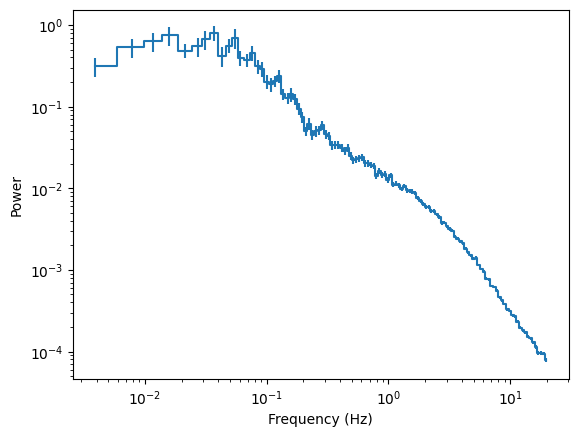

In [2]:
data = np.genfromtxt('power.dat',delimiter=' ')

power = data[:,0]
error = data[:,1]
freq = data[:,2]

plt.figure(1)
plt.errorbar(freq,power,yerr=error,ds="steps-mid")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
gc.collect()

nDspec provides two main functionalities: a set of "operator" objects which convert forward models into whatever units the data is in (counts/s, Fourier lag...), and a set of "fitter" objects for specific data products. Fitter objects run operators "under the hood" to compare models to data, optimize likelihoods, handle models and parameters, and make simple plots. 

Let us start by defining a fitter for our power spectrum, passing it the data we want to fit, and plotting it:

110

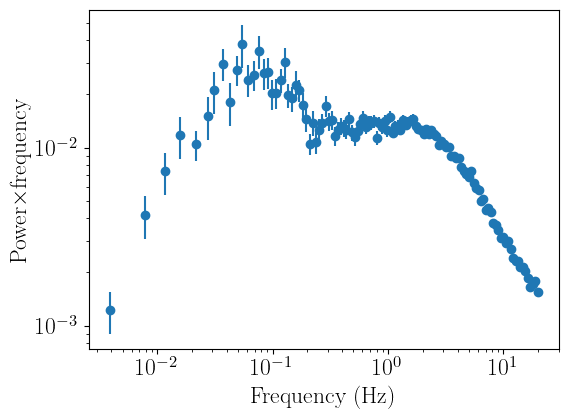

In [3]:
import ndspec.FitPowerSpectrum as fitpsd

psd_fit = fitpsd.FitPowerSpectrum()

psd_fit.set_data(power,data_err=error,data_grid=freq)
psd_fit.plot_data()
gc.collect()

Let's set up the model we will use to fit the data. At a glance, we are probably going to need three broad Lorentzians for broadband noise, with no QPOs.

nDspec comes with its implementation for a Lorentzian, but we can just implement our own in Python as well. After writing our model function, we will define our Model object from the LMFit library, and we can then initialize the model parameters at their value, decide the range over which they can vary, and whether they are free or fixed. 

In [4]:
from lmfit import Model as LM_Model
from lmfit import Parameters as LM_Parameters

#define our Lorentzian model 
def lorentz(freq, peak_f, q, rms):  
    f_res = peak_f/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r = rms/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    lorentz_num = (1/np.pi)*2*r**2*q*f_res
    lorentz_den = 4*q**2*(freq-f_res)**2
    model = lorentz_num/(f_res**2+lorentz_den)
    return model


#define a model instance with three Lorentzians
lorentz_model = LM_Model(lorentz, prefix="l1_") + \
                LM_Model(lorentz, prefix="l2_") + \
                LM_Model(lorentz, prefix="l3_")

#set the initial values, ranges, and whether the parameters can vary
lorentz_params = lorentz_model.make_params(l1_peak_f=dict(value=0.06,min=1e-3,max=0.3,vary=True),
                                           l1_q=dict(value=0.5,min=0.,max=2.,vary=True),
                                           l1_rms=dict(value=0.05,min=1e-3,max=0.3,vary=True),

                                           #make sure that l2 and l3 can't swap to simplify the problem
                                           l2_peak_f=dict(value=0.9,min=0.3,max=1.25,vary=True),
                                           l2_q=dict(value=0.3,min=0,max=2,vary=True),
                                           l2_rms=dict(value=0.15,min=1e-3,max=0.3,vary=True),

                                           l3_peak_f=dict(value=4.0,min=1.25,max=10.0,vary=True),
                                           l3_q=dict(value=0.2,min=0,max=2.,vary=True),
                                           l3_rms=dict(value=0.12,min=1e-3,max=0.3,vary=True))

Once our model and parameter objects are ready, we can pass them to our fitter and plot the model against the data to check whether we are starting in a sensible place

 - Adding parameter "l1_peak_f"
 - Adding parameter "l1_q"
 - Adding parameter "l1_rms"
 - Adding parameter "l2_peak_f"
 - Adding parameter "l2_q"
 - Adding parameter "l2_rms"
 - Adding parameter "l3_peak_f"
 - Adding parameter "l3_q"
 - Adding parameter "l3_rms"


15844

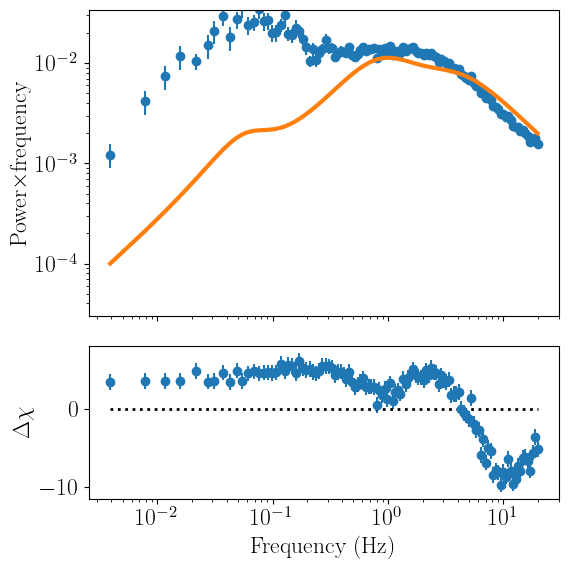

In [5]:
#set the model and run an initial comparison
psd_fit.set_model(lorentz_model)
psd_fit.set_params(lorentz_params)
psd_fit.plot_model()
gc.collect()

It look like the first Lorentzian has too low rms, so let's increase that and check our model again. This time let us also print a summary of the fit statistic with the current model/parameter.

As a big caveat, the alpha version ONLY includes a chi squared statistic.

Goodness of fit metrics:
Chi squared             2046.8620374676784
Reduced chi squared     19.49392416635884
Data bins:              114
Free parameters:        9
Degrees of freedom:     105


27002

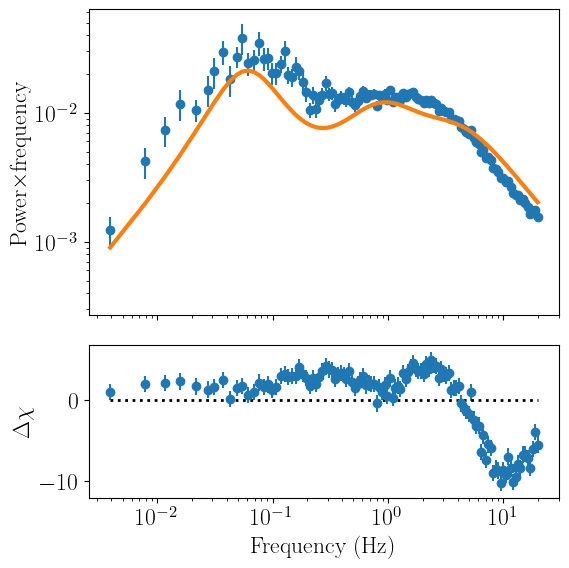

In [6]:
psd_fit.model_params["l1_rms"].value = 0.2
psd_fit.plot_model()
psd_fit.print_fit_stat()
gc.collect()

The model looks somewhat close enough, so we can now just run a statistic optimizer and then plot the resulting fit:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 249
    # data points      = 114
    # variables        = 9
    chi-square         = 110.280036
    reduced chi-square = 1.05028606
    Akaike info crit   = 14.2179893
    Bayesian info crit = 38.8437754
[[Variables]]
    l1_peak_f:  0.06387941 +/- 0.00378598 (5.93%) (init = 0.06)
    l1_q:       0.33420510 +/- 0.07297902 (21.84%) (init = 0.5)
    l1_rms:     0.24969326 +/- 0.00809402 (3.24%) (init = 0.2)
    l2_peak_f:  0.78486030 +/- 0.26730819 (34.06%) (init = 0.9)
    l2_q:       0.08555853 +/- 0.27722611 (324.02%) (init = 0.3)
    l2_rms:     0.16042530 +/- 0.04661727 (29.06%) (init = 0.15)
    l3_peak_f:  2.45162586 +/- 0.44946797 (18.33%) (init = 4)
    l3_q:       0.32984823 +/- 0.17324260 (52.52%) (init = 0.2)
    l3_rms:     0.12323969 +/- 0.05174938 (41.99%) (init = 0.12)


25909

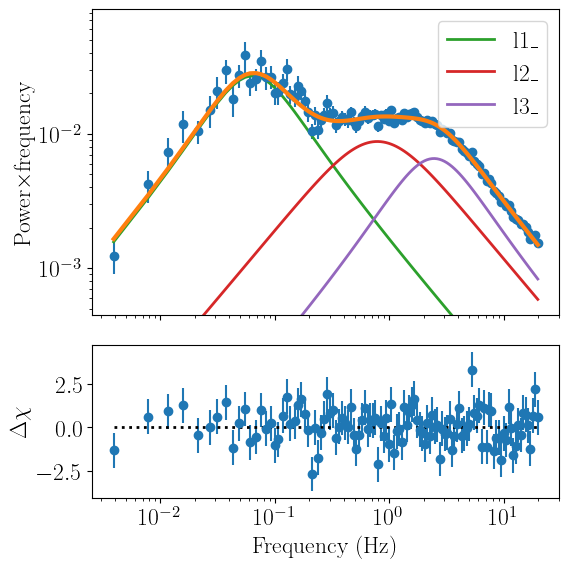

In [7]:
psd_fit.fit_data()
psd_fit.plot_model(plot_components=True)
gc.collect()

We have our first fit! Now we are going to try again, but modelling the modulus and phase of a Freequency-dependent cross spectrum, using a single subject band. Once again, let us begin by loading the data from the files:

In [8]:
#now I am going to try something more complicated - a frequency-dependent cross spectrum, fitting both modulus and phase

with open('cross_oned.dat', 'r') as f:
    lines = f.readlines()

#load the frequency array
data_lines = [line for line in lines[0:2]]
freqs = np.loadtxt(data_lines) 

#load the data columns
data_lines = [line for line in lines[3:]]
data = np.loadtxt(data_lines, usecols=(0, 1))  # Load as 2D array

#Split into data and error
data_arr = data[:, 0]
error_arr = data[:, 1]

For this fit, we will use a different fitter object (FitCrossSpectrum). In addition to the data arrays, we also need to provide the energy ranges for the reference and subject bands. We also need to specify whether our data is a function of Fourier frequency or energy, and whether we are passing the modulus+phase (polar coordinates), real+imaginary parts (cartesian coordinates), or the lag spectrum alone (lags).

In [9]:
#set up my cross spectrum fit
import ndspec.FitCrossSpectrum as fitcross

cross_fit = fitcross.FitCrossSpectrum()
cross_fit.set_coordinates("polar")
cross_fit.set_product_dependence("frequency")

ref_band = [0.5,1.5]
sub_band = [2.,5.]

Once we have done all this set up, we can pass the data to the fitter object, along with the subject and reference bands. 

VERY IMPORTANT: because a cross spectrum is *always* an energy dependent quantity, we also need to pass (and fold) the instrument response matrix. 

In [10]:
#load the response and data into the fitter
from ndspec.Response import ResponseMatrix

rmfpath =  os.getcwd()+"/1200120106_rmf.pha"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/1200120106_arf.pha"
nicer_matrix.load_arf(arfpath)

cross_fit.set_data(nicer_matrix,ref_band,sub_band,
                   data_arr,error_arr,
                   freq_grid=freqs,)

Arf missing, please load it
No exposure header found in ARF, setting exposure time to 1 second
Arf loaded


Plotting the data, we find that we actually seem to have five energy bins. That is because we need:
1) A channel covering from the start of the instrument response, to the start of the reference band
2) A channel covering the reference band
3) A channel covering from the end of the reference band, to the start of the subject band
4) A channel for the subject band
5) A channel from the end of the subject band, to the end of the response matrix

If we skip any of these channels, then we can not fold the instrument response correctly.

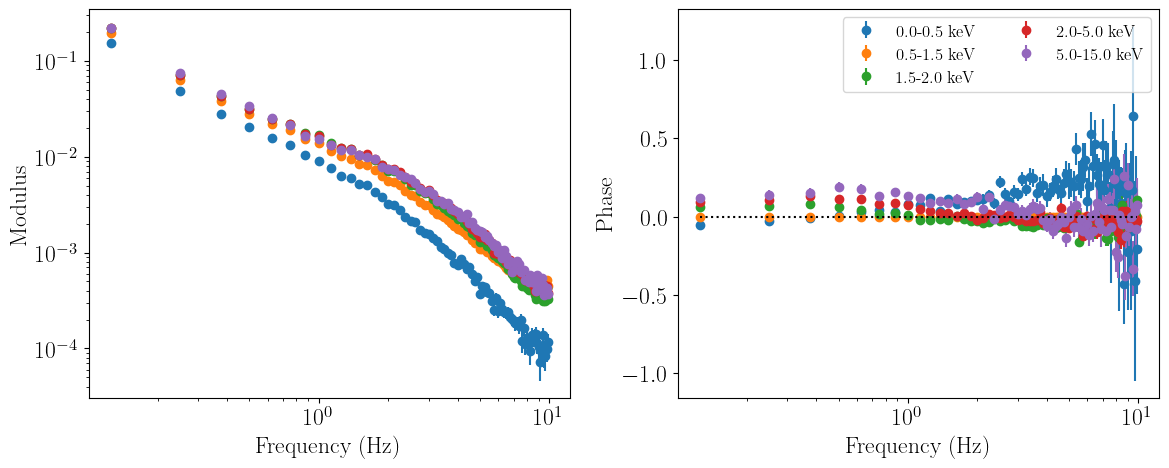

In [11]:
#plot the data
cross_fit.plot_data_1d()

Because we want to model *only* the cross spectrum in the subject band, we will simply ignore all the channels/energies that are not included in it:

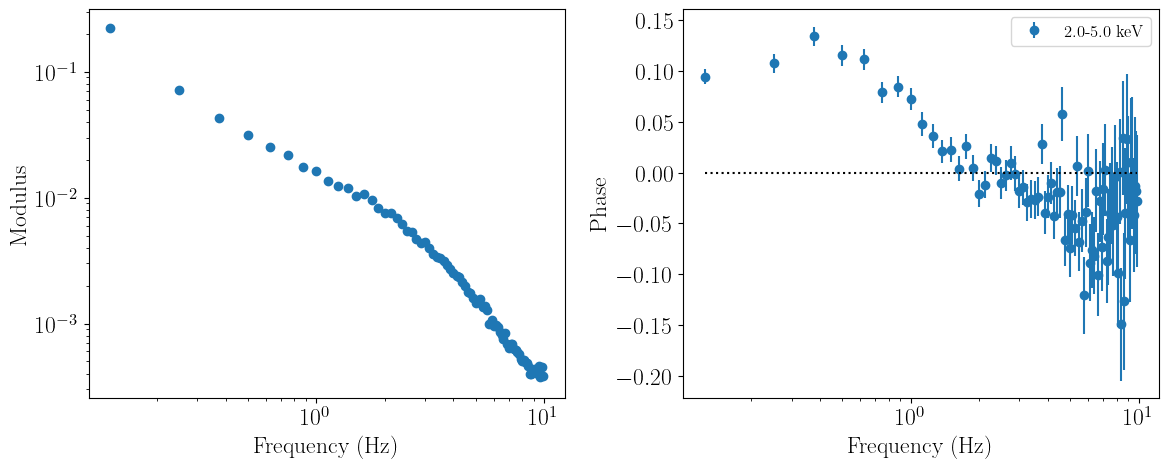

In [12]:
#tell the fitter I only care about the subject band:
cross_fit.ignore_energies(0,2.0)
cross_fit.ignore_energies(5.0,20.0)
cross_fit.plot_data_1d()

Now once again we have to define our model. We are going to use multiple Lorentzians again, but this time we will include an additional phase (like Mariano adding sin/cos functions to the real/imaginary parts) term that encodes a constant phase lag for each Lorentzian.

As a starting point, we are going to use six Lorentzians. Once we have defined our model, we will define our model parameters as a Parameters object from LMFit, similarly to before. 

In [13]:
#now I'm going to define a new Lorentzian function that is shifted by a complex number
def cross_lorentz(energs,freqs,peak_f,q,rms,phase):
    n_energs = len(energs)
    n_freqs = len(freqs)
    #calculate a standard Lorentzian, and include the phase term
    lorentz_arr = lorentz(freqs,peak_f, q, rms)*np.exp(1j*phase)
    #reshape the model into an array of Fourier frequency times energy channels
    twod_lorentz = np.tile(lorentz_arr,n_energs).reshape((n_energs,n_freqs))
    twod_lorentz = np.transpose(twod_lorentz)
    return twod_lorentz

#define our model with six of these functions
CrossLor_model = LM_Model(cross_lorentz, prefix="l1_") + \
                 LM_Model(cross_lorentz, prefix="l2_") + \
                 LM_Model(cross_lorentz, prefix="l3_") + \
                 LM_Model(cross_lorentz, prefix="l4_") + \
                 LM_Model(cross_lorentz, prefix="l5_")+ \
                 LM_Model(cross_lorentz, prefix="l6_")

#create the parameters for each
from lmfit import Parameters as LM_Parameters
Cross_model_parameters = LM_Parameters()
Cross_model_parameters.add_many(('l1_peak_f', 0.05, True, 0, 0.07),
                                ('l1_q', 0.3, True, 0, 2),
                                ('l1_rms', 0.008, True),
                                ('l1_phase', 0.1, True,-np.pi,+np.pi),

                                ('l2_peak_f', 0.3, True, 0.07, 0.5),
                                ('l2_q', 0.5, True, 0, 2),
                                ('l2_rms', 0.003, True),
                                ('l2_phase', 0.3, True,-np.pi,+np.pi),

                                ('l3_peak_f', 1., True, 0.5, 1.5),
                                ('l3_q', 0.7, True, 0, 2),
                                ('l3_rms', 0.002, True),
                                ('l3_phase', 0.1, True,-np.pi,+np.pi),

                                ('l4_peak_f', 2, True, 1.5, 3),
                                ('l4_q', 0.2, True, 0, 2),
                                ('l4_rms', 0.005, True),
                                ('l4_phase', 0, True,-np.pi,+np.pi),

                                ('l5_peak_f', 5, True, 3, 10),
                                ('l5_q', 1, True, 0, 2),
                                ('l5_rms', 0.003, True),
                                ('l5_phase', -0.13, True,-np.pi,+np.pi),

                                ('l6_peak_f', 15, True, 10, 30),
                                ('l6_q', 1.0, True, 0, 8),
                                ('l6_rms', 0.001, True),
                                ('l6_phase', -0.5, True,-np.pi,+np.pi) )

Now that our model and initial parameters are set, we can pass them to the fitter object. Once again, because a cross spectrum is complex and can be modelled with different model types, we need to specify what our model is calculating. Here we calculate the cross spectrum directly, so we tell the fitter that our model type is 'cross'.

In [14]:
#Now I assign the model and parameters to my fit, and I specify what kind of model I am passing
#this is crucially important!!!!
cross_fit.set_model(CrossLor_model,model_type="cross")
cross_fit.set_params(Cross_model_parameters)
cross_fit.model_params.pretty_print()

 - Adding parameter "l1_freqs"
 - Adding parameter "l1_peak_f"
 - Adding parameter "l1_q"
 - Adding parameter "l1_rms"
 - Adding parameter "l1_phase"
 - Adding parameter "l2_freqs"
 - Adding parameter "l2_peak_f"
 - Adding parameter "l2_q"
 - Adding parameter "l2_rms"
 - Adding parameter "l2_phase"
 - Adding parameter "l3_freqs"
 - Adding parameter "l3_peak_f"
 - Adding parameter "l3_q"
 - Adding parameter "l3_rms"
 - Adding parameter "l3_phase"
 - Adding parameter "l4_freqs"
 - Adding parameter "l4_peak_f"
 - Adding parameter "l4_q"
 - Adding parameter "l4_rms"
 - Adding parameter "l4_phase"
 - Adding parameter "l5_freqs"
 - Adding parameter "l5_peak_f"
 - Adding parameter "l5_q"
 - Adding parameter "l5_rms"
 - Adding parameter "l5_phase"
 - Adding parameter "l6_freqs"
 - Adding parameter "l6_peak_f"
 - Adding parameter "l6_q"
 - Adding parameter "l6_rms"
 - Adding parameter "l6_phase"
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
l1_peak_f      0.05     

As before, we can change the values of the parameters stored:

In [15]:
#let us now show all the parameters and change the value of one:
print("-----------------------------")
cross_fit.model_params["l1_peak_f"].value=0.04
cross_fit.model_params.pretty_print()

-----------------------------
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
l1_peak_f      0.04        0     0.07     None     True     None     None
l1_phase        0.1   -3.142    3.142     None     True     None     None
l1_q            0.3        0        2     None     True     None     None
l1_rms        0.008     -inf      inf     None     True     None     None
l2_peak_f       0.3     0.07      0.5     None     True     None     None
l2_phase        0.3   -3.142    3.142     None     True     None     None
l2_q            0.5        0        2     None     True     None     None
l2_rms        0.003     -inf      inf     None     True     None     None
l3_peak_f         1      0.5      1.5     None     True     None     None
l3_phase        0.1   -3.142    3.142     None     True     None     None
l3_q            0.7        0        2     None     True     None     None
l3_rms        0.002     -inf      inf     None     True     None     None
l4_pea

Having set everything up, running and plotting the fit is identical to the previous fit:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4451
    # data points      = 158
    # variables        = 24
    chi-square         = 167.558107
    reduced chi-square = 1.25043363
    Akaike info crit   = 57.2801558
    Bayesian info crit = 130.782437
[[Variables]]
    l1_peak_f:  0.06999576 +/- 0.64869977 (926.77%) (init = 0.04)
    l1_q:       0.15168471 +/- 3.69650468 (2436.97%) (init = 0.3)
    l1_rms:     0.00811670 +/- 0.03381576 (416.62%) (init = 0.008)
    l1_phase:   0.09206859 +/- 0.01107578 (12.03%) (init = 0.1)
    l2_peak_f:  0.39332794 +/- 0.06101403 (15.51%) (init = 0.3)
    l2_q:       1.04693005 +/- 0.82233559 (78.55%) (init = 0.5)
    l2_rms:     0.00158749 +/- 0.00247202 (155.72%) (init = 0.003)
    l2_phase:   0.35119911 +/- 0.83213237 (236.94%) (init = 0.3)
    l3_peak_f:  0.73874762 +/- 0.09971295 (13.50%) (init = 1)
    l3_q:       0.83256670 +/- 0.64279292 (77.21%) (init = 0.7)
    l3_rms:     0.00252612 +/- 0.00253489 (100.35%) (i

23762

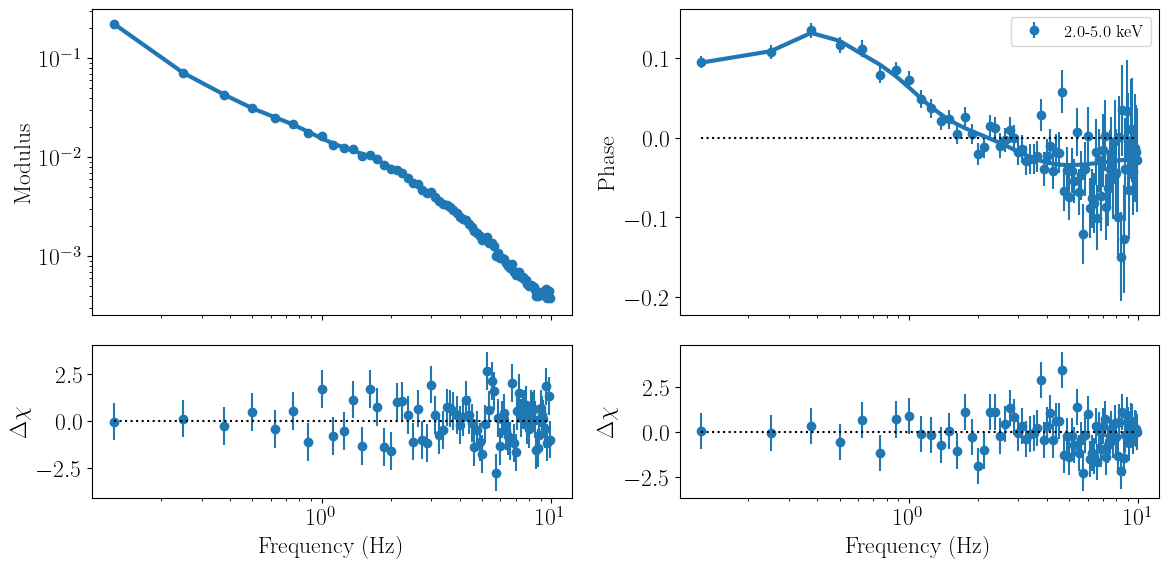

In [16]:
cross_fit.fit_data()
cross_fit.plot_model_1d()
gc.collect()

As the final and most complex (well, complicated...) fit, we will model six lag-energy spectra with a combination of a time-domain imupulse response function, and a Fourier domain transfer function.

We will start once again with loading the data from text files into flattened numpy arrays.

In [17]:
#finally let us fit many lag-energy spectra together 
with open('lags_twod.dat', 'r') as f:
    lines = f.readlines()

#load the frequency array over which the lag spectra are built
data_lines = [line for line in lines[0:2]]
freqs = np.loadtxt(data_lines) 

#load the energy channel array over which we calculated the lags
data_lines = [line for line in lines[2:4]]
energs = np.loadtxt(data_lines) 

#load the data columns
data_lines = [line for line in lines[4:]]
data = np.loadtxt(data_lines, usecols=(0, 1))  

#Split into data and error
data_arr = data[:, 0]
error_arr = data[:, 1]

Let us set up a new fitter object, specify that our data coordinates are lags, that the lag spectra depend on energy. We also need to keep track of what reference band is being used, and of the energies for each subject band used. 

Because we will be using both time and Fourier domain models, we need to also specify the time resolution and segment size that was used to build the lag spectra. This is needed to build internal grids of both time and Fourier frequency, which the code will use to calculate the models.

In [18]:
#specify what kind of fit we want to run and load the data
lags_fit = fitcross.FitCrossSpectrum()
lags_fit.set_coordinates("lags")
lags_fit.set_product_dependence("energy")

dt = 0.03
segment_size = 5
ref_band = [0.5, 10]

#load response matrix, reference band, energy channels and frequency bins used, time resolution used, and the lags+data
lags_fit.set_data(nicer_matrix,ref_band,energs,
                  data_arr,error_arr,
                  freq_bins=freqs,
                  time_res=dt,seg_size=segment_size)

As before, we will ignore the data near the extremes of the response.

If we want to plo tour data, nDspec offers a few options to make visualizing the cross spectrum more easily. We can use both one and two-dimensional plots, and for ease of visualization we can also convert from time lags to phase.

39673

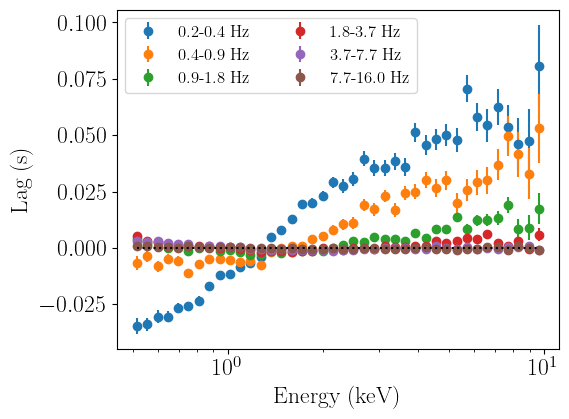

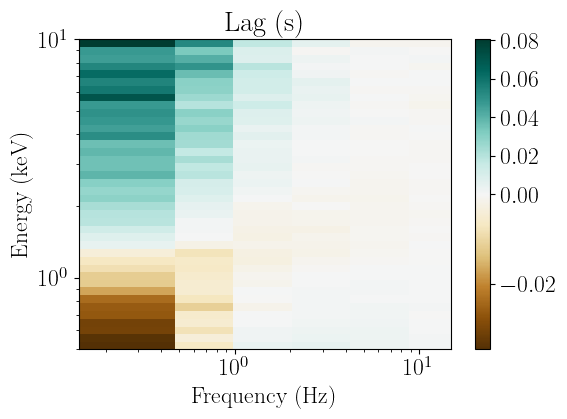

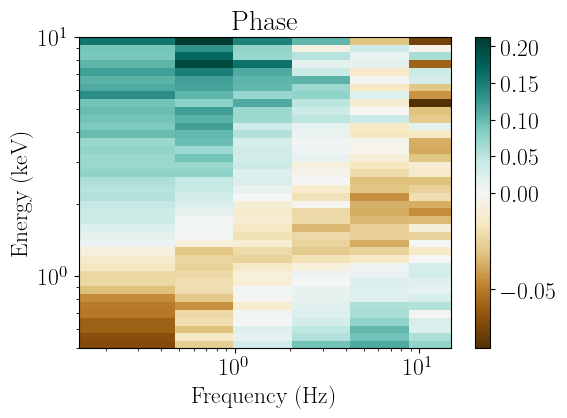

In [19]:
lags_fit.ignore_energies(0,0.5)
lags_fit.ignore_energies(10.0,20.0)
lags_fit.plot_data_1d()
lags_fit.plot_data_2d()
lags_fit.plot_data_2d(use_phase=True)
gc.collect()

Before defining our models and running the fit, let's look at a quick refresher on impulse response and transfer functions. Say we have a signal $f(E,t)$ defined in an energy band $E$ as a function of time $t$. An impulse response function is a function that can represent our signal as:

$$
    f(E,t) = s(t) \ast g(E,t)
$$

here, $s(t)$ is some underlying process causing the variabiltiy, and $g(E,t)$ characterizes the response of a system to a delta perturbation (like a flash of mono-energetic photons). $g(E,t)$ is called the impulse response function of the system, and is one of the types of models supported for cross spectra in nDspec.

The power of impulse response functions is obvious in the Fourier domain. Taking the Fourier transform of the equation above we have:

$$
    F(E,\nu) = S(\nu) G(E,\nu)
$$

here, $G(E,\nu)$ is called a transfer function, and is the Fourier transform of the impulse response function. nDspec also supports models for transfer functions. Note how the (computationally expensive) convolution in the time domain has now been turned into a trivial product in the Fourier domain!

We can derive our model cross spectrum from these Fourier transforms. Taking a reference band $E_{ref}$ we have:

$$
    C(E,\nu) = S(\nu)G(E,\nu) S^{*}(\nu)G^{*}(E_{ref},\nu) = S^{2}(\nu) G(E,\nu) G^{*}(E_{ref},\nu)
$$

By definition, $S(\nu)$ is the power spectrum of whatever is causing the variability, and all the energy dependence is carried by $g(E,t)$ and therefore $G(E,\nu)$. In this fit, we will assume a shape for $S(\nu)$ and combine two model components, one with an impulse response and another with a transfer function.

Once again, we begin by defining our model. We will include tbabs with a terrible wrapper of PyXspec (which will not be needed soon!). We will then include a component for a pivoting power-law, in the form of a transfer function provided through nDspec, which is very similar to that in Reltrans. This will account for the hard lags in the data.

In [20]:
#for now we need to do a gross thing for tbabs, this is fixed in the beta!
from scipy.interpolate import interp1d
from xspec import *
import ndspec.models as models

Xset.chatter = 0

#wrap PyXspec for tbabs
#this is awful
def wrap_tbabs(energs,nH):
    model = Model("tbabs*po")
    model.TBabs.nH = nH
    model.powerlaw.PhoIndex = 0.0
    model.powerlaw.norm = 1.0
    Plot("model")
    tbabs_x = np.array(Plot.x())
    tbabs_y = np.array(Plot.model())
    interp_obj = interp1d(tbabs_x,tbabs_y,fill_value='extrapolate')
    model = interp_obj(energs)
    return model

#for pivoting powerlaw and thermal reverberation, we can use the ndspec implementation!
#this is defined in the Fourier domain as a transfer function
def pivoting(energs,freqs,norm_pl,pl_index,gamma_0,s_gamma,phi_0,s_phi,nu_0):
    param_array = np.array([norm_pl,pl_index,gamma_0,s_gamma,phi_0,s_phi,nu_0])
    model = np.transpose(models.pivoting_pl(freqs,energs,param_array))
    return model

For the soft lags, we will use a phenomenological impulse respones function, consisting of a black body flash whose normalization rises and then decays following two powerlaws in time, and whose temperature also decays following a powerlaw in time. We will write a model function that converts this time domain function into a transfer function, using the CrossSpectrum class provided by nDspec.

In [21]:
#the reverberation models are defined in the time domain, so we need to define a cross spectrum to
#convert it to a transfer function to then return to the software
from ndspec.Timing import CrossSpectrum

def reverb(energs,times,rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope):
    param_array = np.array([rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope])
    impulse_response = models.bbody_bkn(times,energs,param_array)
    #these lines convert our time domain model into a Fourier domain one
    cross_spec = CrossSpectrum(times,energ=energs)
    cross_spec.set_impulse(impulse_response)
    cross_spec.transfer_from_irf()
    model = np.transpose(cross_spec.trans_func)
    return model

Finally, for our power spectrum $S(\nu)$, we will simply take a mix of three Lorentzians identical to those of our fitted power spectrum. Note that this is strictly not correct, and "copying" our power spectrum is just an educated guess. 

In [22]:
from ndspec.Timing import PowerSpectrum

#Finally, let us build a model for the power spectrum to be included 
psd = PowerSpectrum(lags_fit._times)
#set Lorentzian parameters from the PSD fit
l1_pars = np.array([0.06,0.33,0.25])
l2_pars = np.array([0.78,0.08,0.16])
l3_pars = np.array([2.45,0.32,0.12])
psd_model = models.lorentz(psd.freqs,l1_pars)+models.lorentz(psd.freqs,l2_pars)+models.lorentz(psd.freqs,l3_pars)
psd.power_spec = psd_model

Having put all of our model functions together, we can just create our model object and parameters and pass them to the fitter.

Note that because we convert our impulse response function into a transfer function in the model definition, the output of all of our models is a transfer function, and therefore we set model_type="transfer"

In [23]:
lag_model = LM_Model(wrap_tbabs)*(LM_Model(pivoting,independent_vars=['energs','freqs'])+
                                     LM_Model(reverb,independent_vars=['energs','times']))

start_params = lag_model.make_params(nH=dict(value=0.1,min=0.08,max=0.2,vary=True),
                                     norm_pl=dict(value=1,min=1e-3,max=1e4,vary=False),
                                     pl_index=dict(value=-1.6,min=-1.8,max=-1.4,vary=False),
                                     gamma_0=dict(value=0.046,min=0,max=0.5,vary=True),
                                     s_gamma=dict(value=-0.0016,min=-0.1,max=0,vary=True),
                                     phi_0=dict(value=-2.,min=-np.pi,max=np.pi,vary=True),
                                     s_phi=dict(value=2.,min=-3.,max=3.0,vary=True),
                                     nu_0=dict(value=lags_fit.freq_bounds[0],min=0.0001,max=10,vary=False),
                                     rev_norm=dict(value=1.7,min=0,max=1e4,vary=True),
                                     rev_temp=dict(value=0.50,min=0.01,max=0.8,vary=True),
                                     rise_slope=dict(value=3,min=0,max=10,vary=False),
                                     decay_slope=dict(value=-2.,min=-10,max=0,vary=True),
                                     peak_time=dict(value=0.006,min=0.0,max=0.2,vary=True),
                                     temp_slope=dict(value=-0.4,min=-3,max=0,vary=True),
                                     )


lags_fit.set_model(lag_model,model_type="transfer")
lags_fit.set_psd_weights(psd)
lags_fit.set_params(start_params)

 - Adding parameter "nH"
 - Adding parameter "norm_pl"
 - Adding parameter "pl_index"
 - Adding parameter "gamma_0"
 - Adding parameter "s_gamma"
 - Adding parameter "phi_0"
 - Adding parameter "s_phi"
 - Adding parameter "nu_0"
 - Adding parameter "rev_norm"
 - Adding parameter "rev_temp"
 - Adding parameter "rise_slope"
 - Adding parameter "decay_slope"
 - Adding parameter "peak_time"
 - Adding parameter "temp_slope"


/home/matteo/Software/nDspec/src/ndspec/models.py:205: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/denom**2
/home/matteo/Software/nDspec/src/ndspec/models.py:200: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)


41414

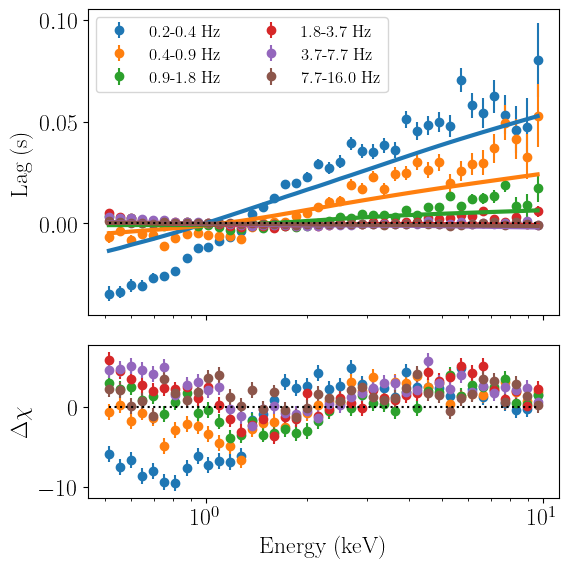

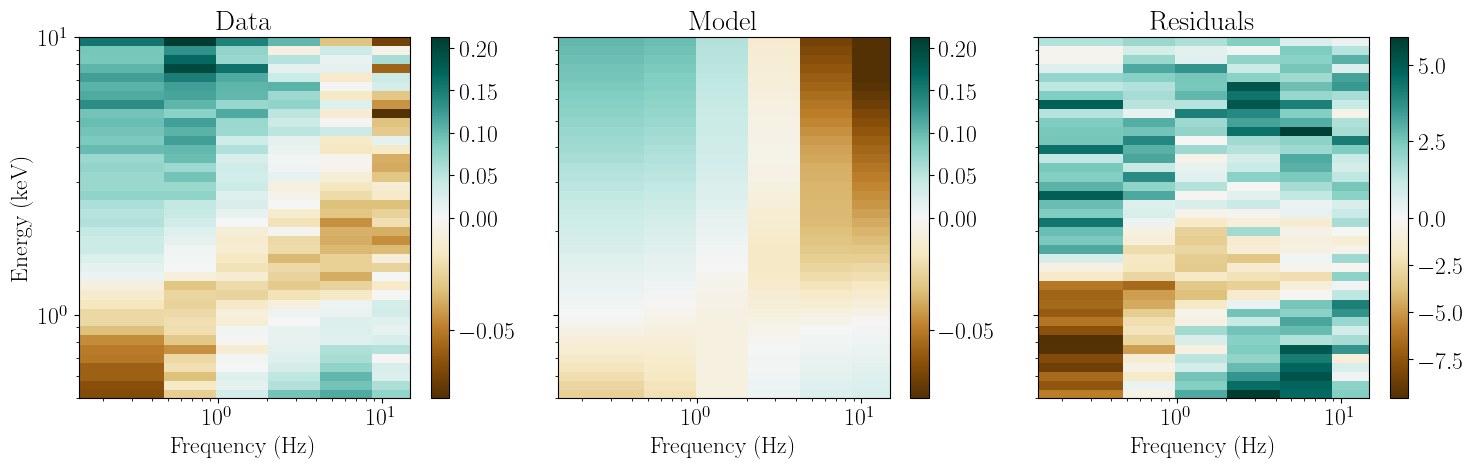

In [24]:
lags_fit.plot_model_1d()
lags_fit.plot_model_2d(use_phase=True)
gc.collect()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1602
    # data points      = 240
    # variables        = 10
    chi-square         = 671.350768
    reduced chi-square = 2.91891638
    Akaike info crit   = 266.876680
    Bayesian info crit = 301.683069
[[Variables]]
    nH:           0.20000000 +/- 0.05403789 (27.02%) (init = 0.1)
    norm_pl:      1 (fixed)
    pl_index:    -1.6 (fixed)
    gamma_0:      0.07549036 +/- 0.00737349 (9.77%) (init = 0.046)
    s_gamma:     -0.02911928 +/- 0.00681245 (23.39%) (init = -0.0016)
    phi_0:       -2.17601960 +/- 0.15118908 (6.95%) (init = -2)
    s_phi:        1.96448614 +/- 0.17358696 (8.84%) (init = 2)
    nu_0:         0.2 (fixed)
    rev_norm:     1.61248212 +/- 1001.86143 (62131.63%) (init = 1.7)
    rev_temp:     0.62082671 +/- 0.04732176 (7.62%) (init = 0.5)
    rise_slope:   3 (fixed)
    decay_slope: -1.52535480 +/- 0.11269302 (7.39%) (init = -2)
    peak_time:    0.00564770 +/- 2.30111823 (40744.31%) (in

/home/matteo/Software/nDspec/src/ndspec/models.py:205: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/denom**2
/home/matteo/Software/nDspec/src/ndspec/models.py:200: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)


65558

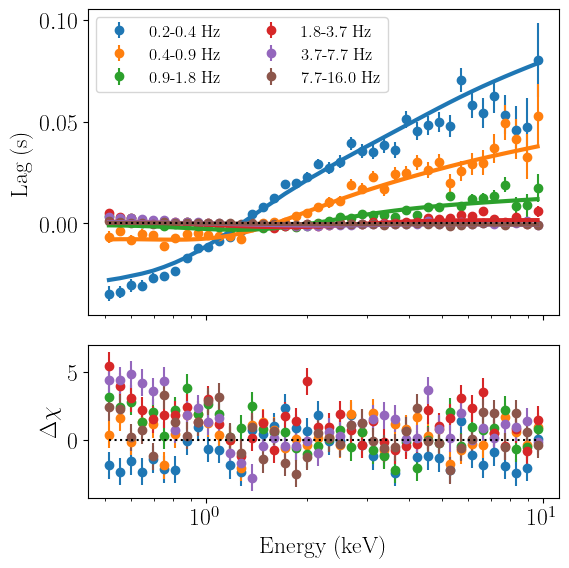

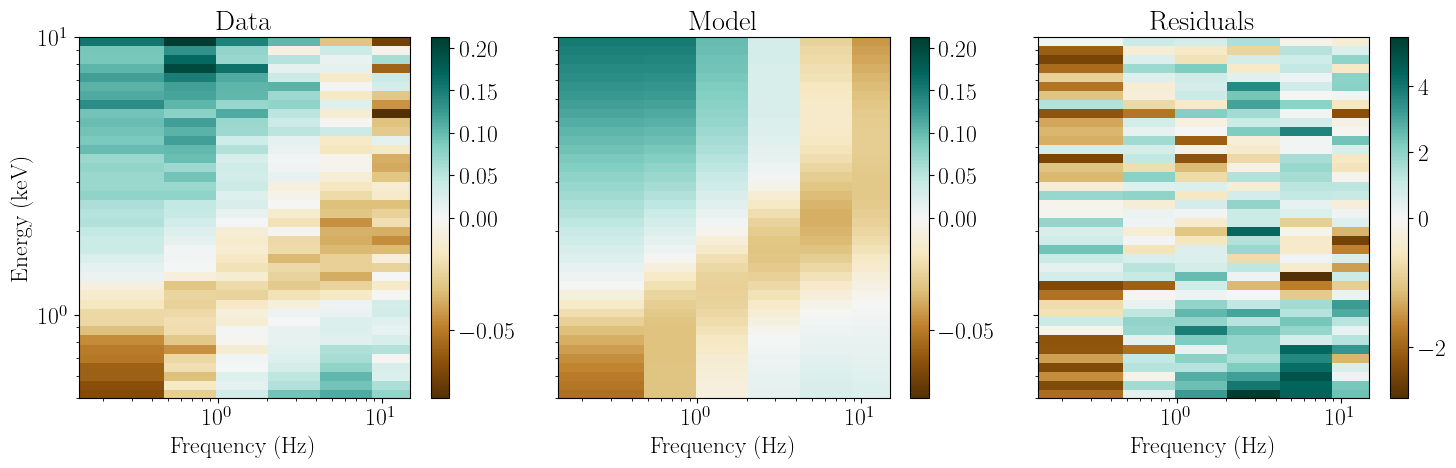

In [25]:
lags_fit.fit_data()
lags_fit.plot_model_1d()
lags_fit.plot_model_2d(use_phase=True)
gc.collect()

Finally, now that we have found a semi reasonable fit to the data, we can go back and plot our reverberation impulse response function, starting from the best-fitting parameters we found

/home/matteo/Software/nDspec/src/ndspec/models.py:205: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/denom**2
/home/matteo/Software/nDspec/src/ndspec/models.py:200: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)


65019

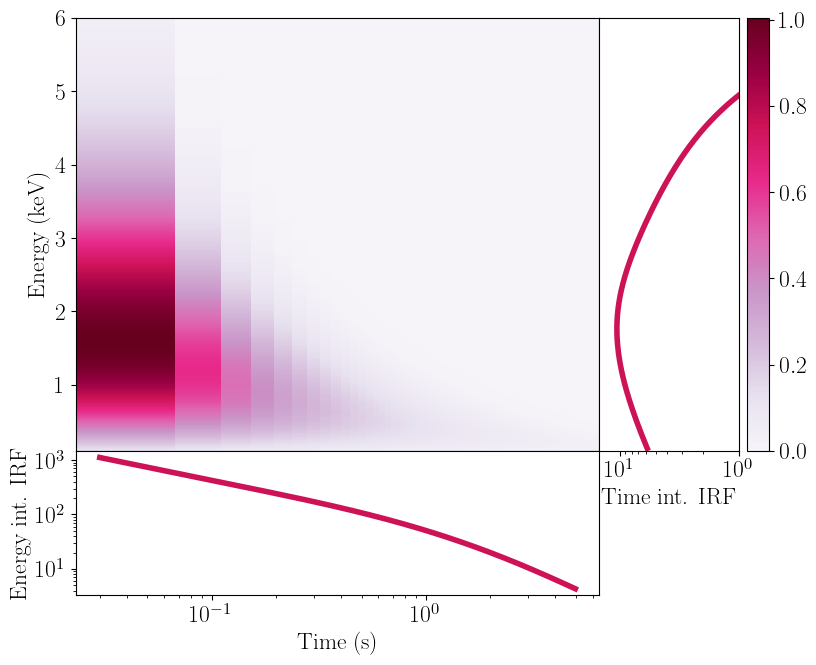

In [26]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

#let us plot the impulse response from the best fit
param_array = np.array([lags_fit.model_params["rev_norm"].value,
                        lags_fit.model_params["rev_temp"].value,
                        lags_fit.model_params["rise_slope"].value,
                        lags_fit.model_params["decay_slope"].value,
                        lags_fit.model_params["peak_time"].value,
                        lags_fit.model_params["temp_slope"].value])

impulse_response, energ_profile, pulse_profile = models.bbody_bkn(lags_fit._times,lags_fit.energs,param_array,return_full=True)


fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200)
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(lags_fit._times,lags_fit.energs,impulse_response,cmap="PuRd",
                 shading='auto',linewidth=0,rasterized=True)
ax.set_ylabel("Energy (keV)")
ax.set_xlabel("Time (s)")
ax.set_xscale("log")
ax.set_ylim([0.1,6])

side.loglog(energ_profile,lags_fit.energs,lw=4,color=colorscale[3])
side.set_ylabel("Energy (keV)")
side.set_xlabel("Time int. IRF")
side.set_ylim([0.1,6])
side.set_xlim([1,15])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.yaxis.set_visible(False)

below.loglog(lags_fit._times,pulse_profile,lw=4,color=colorscale[3])
below.set_xlabel("Time (s)")
below.set_ylabel("Energy int. IRF")

fig.colorbar(c, ax=side)

gc.collect()

As a final experiment, we can try to run a Bayesian sampler on one of our fits to try to find the credible intervals/error bars for the best-fitting parameters. Let us do this for the fit of the power spectrum, since it is a much simpler problem. First, we need to tell our sampler what the data, model, and parameters to sample are. 

Having done that, we will also set the number of walkers and steps to be used, and initialize the walkers within 1% of the values found by the best fit above.

In [27]:
#bonus feature: let us try a simple Bayesian sampling run
import ndspec.EmceeUtils as ndmc

#let us tell my sampling code what the data, model, and initial position are
ndmc.set_emcee_data(psd_fit)
ndmc.set_emcee_model(psd_fit)
theta = ndmc.set_emcee_parameters(psd_fit.model_params)

#set up the remaining parameters for my sampler
nwalkers = 32
ndim = len(theta)
steps = 15000
#pos is the initial positions of the walkers - we will set it to be within 1% of the best fitting values
pos = theta*(1+ 1e-2 * np.random.randn(nwalkers, len(theta)))

The next step is setting up the priors. MCMC samplers will NOT run at all without specifying priors - in other software they are sort of assumed to be there if we don't specify them. 

The only thing we will do in this tutorial is set uniform priors, and force the second and third Lorentzian to be separate in frequency. 

In [ ]:
#now I MUST define my priors 
#for each, pass a minum and maximum value, then group them in a dictionary.
l1_peak_prior = ndmc.priorUniform(0,0.3)
l1_q_prior = ndmc.priorUniform(1e-5,2)
l1_rms_prior = ndmc.priorUniform(1e-3,1)

l2_peak_prior = ndmc.priorUniform(1e-1,1.25)
l2_q_prior = ndmc.priorUniform(1e-5,2)
l2_rms_prior = ndmc.priorUniform(1e-3,1)

l3_peak_prior = ndmc.priorUniform(1.25,10)
l3_q_prior = ndmc.priorUniform(1e-5,2)
l3_rms_prior = ndmc.priorUniform(1e-3,1)

my_priors = {
    "l1_peak_f": l1_peak_prior,
    "l1_q": l1_q_prior,
    "l1_rms": l1_rms_prior,
    "l2_peak_f": l2_peak_prior,
    "l2_q": l2_q_prior,
    "l2_rms": l2_rms_prior,
    "l3_peak_f": l3_peak_prior,
    "l3_q": l3_q_prior,
    "l3_rms": l3_rms_prior,
}

ndmc.set_emcee_priors(psd_fit,my_priors)

#sanity check that my parameters are starting in the right spot
likelihood = ndmc.chi_square_likelihood(theta)
print(likelihood)

Having done all the above, we can run our sampler and then process the results. 

In [ ]:
#now we finally run our sampler
import emcee
import time
import corner

bayesian_sampler = emcee.EnsembleSampler(nwalkers, ndim, ndmc.chi_square_likelihood)
start = time.time()
bayesian_sampler.run_mcmc(pos, steps, progress=True);
end = time.time()
multi_time = end - start
print("Emcee took {0:.1f} seconds".format(multi_time))

In [ ]:
#the chain did not converge! let us ignore it anyway...
#THIS IS REALLY REALLY BAD WE SHOULD NOT DO THIS IN OUR PAPERS 
tau = bayesian_sampler.get_autocorr_time()
print("Autocorrelation lengths:",tau)

In [ ]:
#let us grab the values and parameter names from the fitter anyway
fit_names = []
fit_values = []
for key in psd_fit.model_params:
    fit_names = np.append(fit_names,psd_fit.model_params[key].name)
    fit_values = np.append(fit_values,psd_fit.model_params[key].value)


flat_samples = bayesian_sampler.get_chain(discard=2500, thin=150, flat=True)
fig = corner.corner(flat_samples,labels=fit_names,truths=fit_values)
gc.collect()